# Using Facebook's Prophet for Time Series Prediction
Reference: https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775

Feature descriptions can be found at: https://www.kaggle.com/sayakchakraborty/air-quality-prediction-of-relative-humidity

In [48]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt

In [2]:
data=pd.read_csv("AirQualityUCI.csv",sep=';')
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
Date             9357 non-null object
Time             9357 non-null object
CO(GT)           9357 non-null object
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null float64
C6H6(GT)         9357 non-null object
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
T                9357 non-null object
RH               9357 non-null object
AH               9357 non-null object
Unnamed: 15      0 non-null float64
Unnamed: 16      0 non-null float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


---------------------------------------------------------------------------------------------------------------

# Data Cleaning          
                    
1) Remove NaNs               
2) Many float values have , instead of .  -> change to float dtype               
3) Hourly data provided -> convert to daily or weekly to see smoother graphs               
4) Some values are < 0 -> maybe sensor errors? To be ignored                

In [4]:
data['Date']=pd.to_datetime(data['Date'])

In [5]:
#Convert to float - need to change the , to . first
for col in data.columns[2:]:
    if data[col].dtypes == object:
        data[col] = data[col].str.replace(',', '.').astype('float')

In [6]:
#Get daily data:
dailyData=data.drop('Time',axis=1).groupby('Date').apply(lambda x:x[x>0].mean())
dailyData.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
Date,,,,,,,,,,,,,,,
2004-01-04,2.550000,1244.380952,310.125,11.971429,1010.428571,161.304348,880.666667,96.739130,1644.380952,1155.857143,15.519048,51.133333,0.854881,NaN,NaN
2004-01-05,2.056522,1097.500000,275.000,8.662500,913.708333,104.739130,918.083333,84.956522,1640.416667,904.625000,20.150000,52.183333,1.167312,NaN,NaN
2004-01-06,2.100000,1135.583333,NaN,12.375000,1021.875000,152.043478,896.791667,75.869565,1881.500000,1066.958333,20.325000,66.154167,1.533350,NaN,NaN
2004-01-07,2.162500,1130.583333,NaN,12.225000,1038.541667,139.695652,740.916667,113.434783,1854.250000,1059.625000,30.450000,39.691667,1.624108,NaN,NaN
2004-01-08,0.983333,974.166667,NaN,5.808333,792.583333,51.739130,880.083333,58.521739,1559.000000,670.583333,30.654167,42.120833,1.673521,NaN,NaN


In [7]:
#Removing NaNs -> Criteria: Drop cols with >10 NaNs (391 rows only), drop the remaining rows with NaNs
dailyData=dailyData.iloc[:,(dailyData.isna().sum()<=10).values]
dailyData=dailyData.dropna()
dailyData.head()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,
2004-01-04,1244.380952,11.971429,1010.428571,880.666667,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-05,1097.500000,8.662500,913.708333,918.083333,1640.416667,904.625000,20.150000,52.183333,1.167312
2004-01-06,1135.583333,12.375000,1021.875000,896.791667,1881.500000,1066.958333,20.325000,66.154167,1.533350
2004-01-07,1130.583333,12.225000,1038.541667,740.916667,1854.250000,1059.625000,30.450000,39.691667,1.624108
2004-01-08,974.166667,5.808333,792.583333,880.083333,1559.000000,670.583333,30.654167,42.120833,1.673521


In [8]:
# Get weekly data:
weeklyData = dailyData.resample('W').mean()
weeklyData.head()
# A lot of NaNs seen. May not be that useful afterall since data is not available for everyday

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date,,,,,,,,,
2004-01-04,1244.380952,11.971429,1010.428571,880.666667,1644.380952,1155.857143,15.519048,51.133333,0.854881
2004-01-11,1136.801760,11.674457,1009.344462,760.484990,1727.833075,1083.683747,24.564726,53.224017,1.526858
2004-01-18,1173.375000,13.429167,1050.458333,1490.333333,1448.541667,1196.333333,10.891667,77.000000,1.002796
2004-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
def plotCol(colname):
    plt.figure(figsize=(12,8))
    plt.plot(dailyData[colname])
    plt.xlabel('Time (Day/Week)')
    plt.ylabel(colname)
    plt.title("Time vs "+colname)
    plt.show()

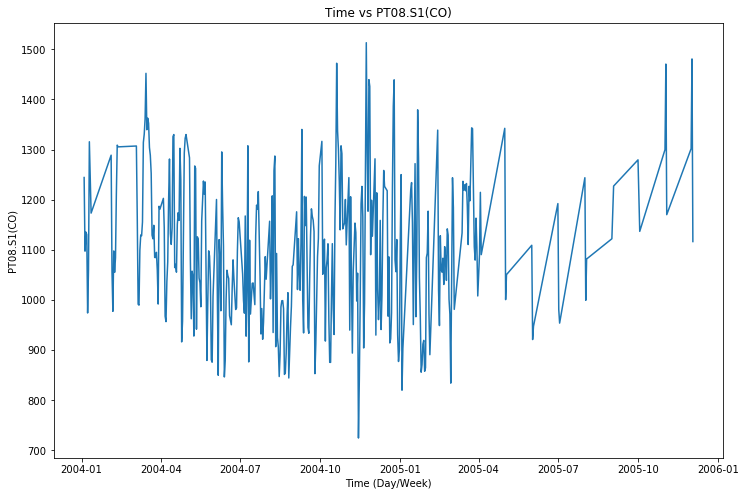

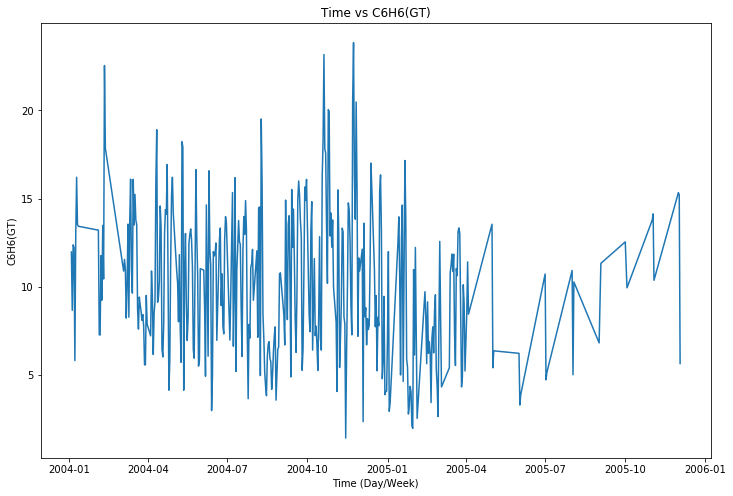

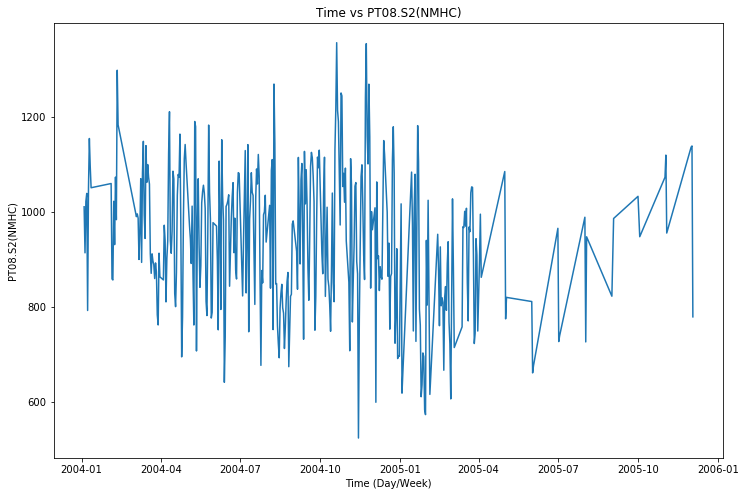

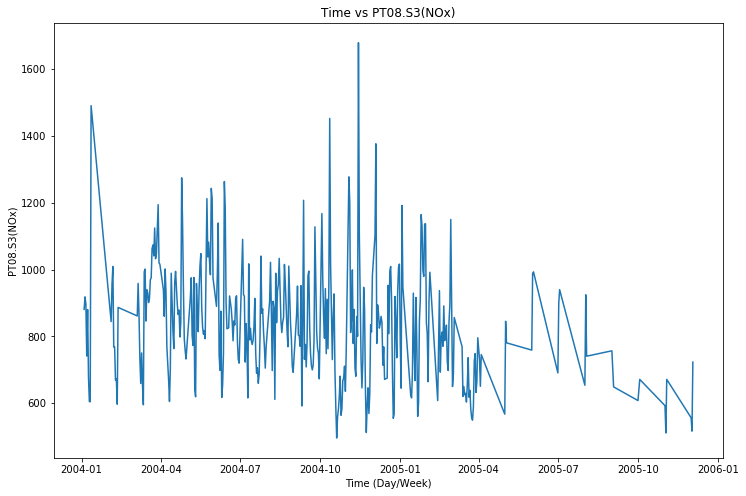

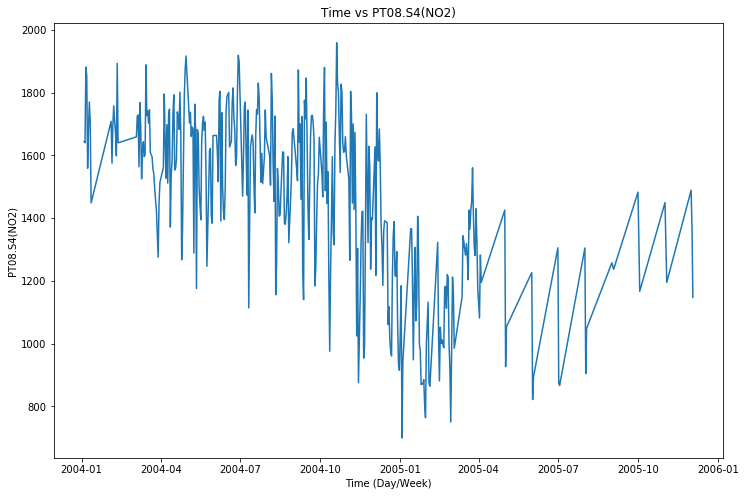

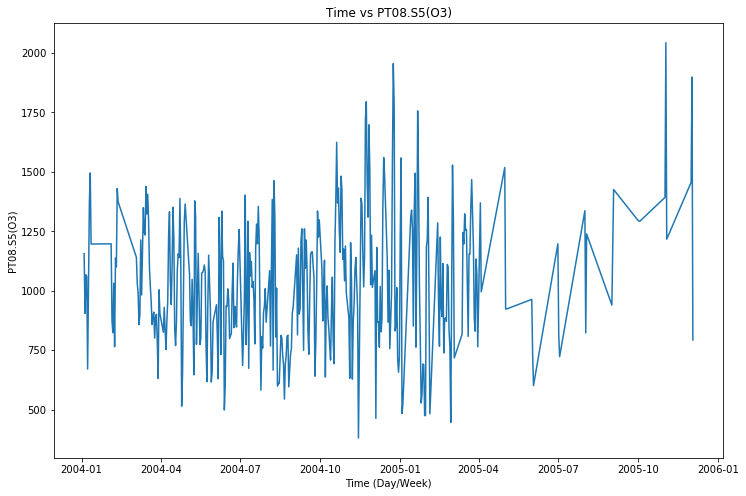

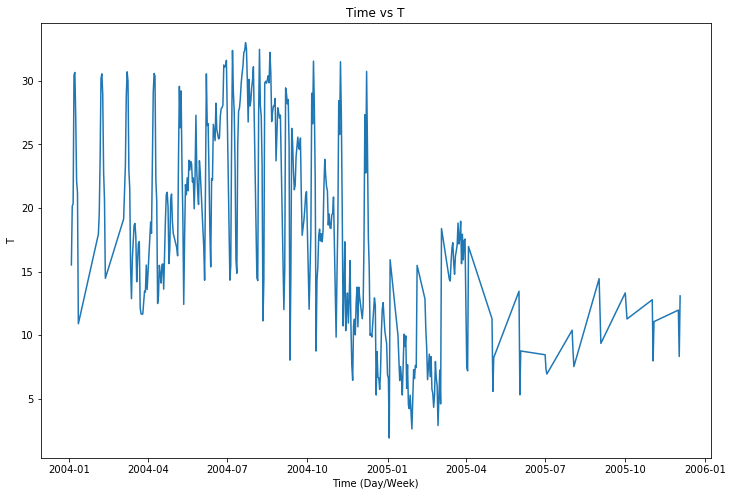

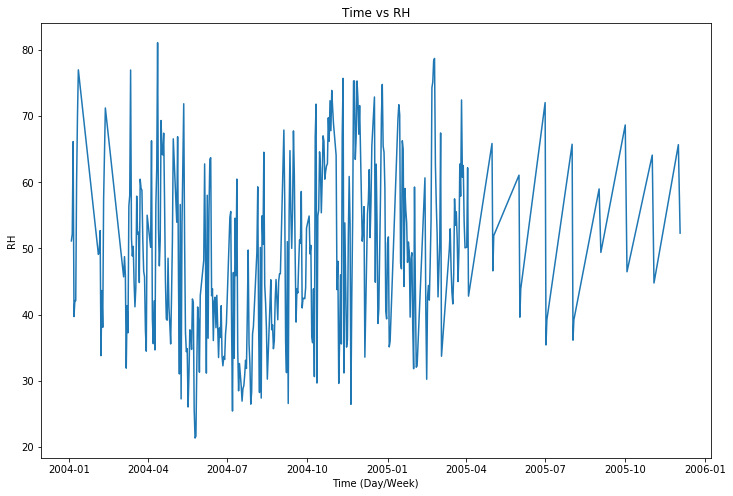

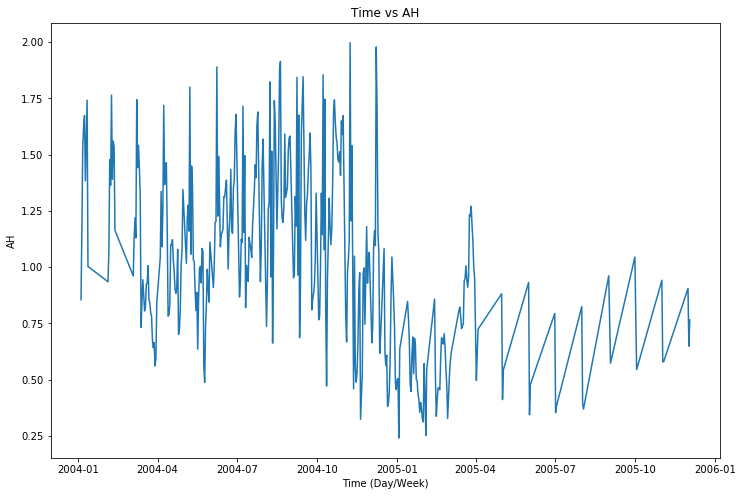

In [10]:
for c in dailyData.columns:
    plotCol(c)

# Model data
              
- Use only one attribute to visualize easily and be able to use Prophet.
- We only predict NOx levels (most important in determining air quality)

In [11]:
dailyData.drop([col for col in dailyData.columns if col!='PT08.S3(NOx)'],axis=1,inplace=True)
dailyData.head()

,PT08.S3(NOx)
Date,
2004-01-04,880.666667
2004-01-05,918.083333
2004-01-06,896.791667
2004-01-07,740.916667
2004-01-08,880.083333


# Check seasonality and stationarity

In [43]:
def dickeyFullerPlot(data,lag=10):
    plt.figure(figsize=(12,8))
    p=sm.tsa.stattools.adfuller(data)[1]
    plt.title('Dickey-Fuller Plot, p='+str(p))
    plt.plot(data)
    plt.show()

In [44]:
def plotAutoCorr(data,lag=10):
    plt.figure(figsize=(12,8))
    ax=plt.subplot()
    smt.graphics.plot_acf(data, lags=lag, ax=ax)

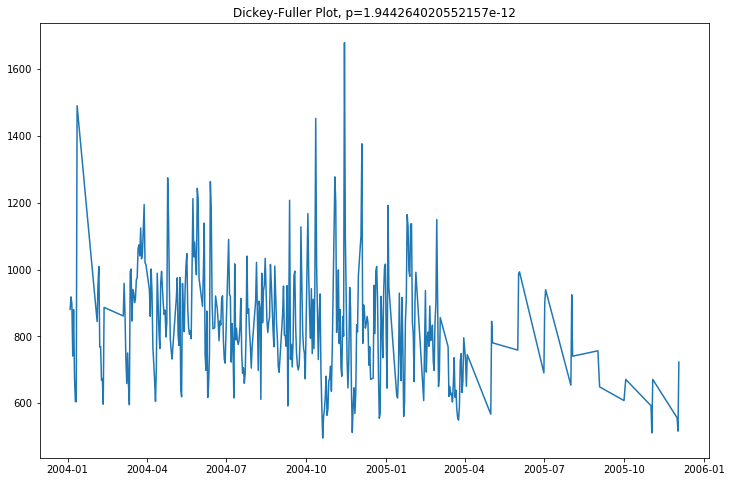

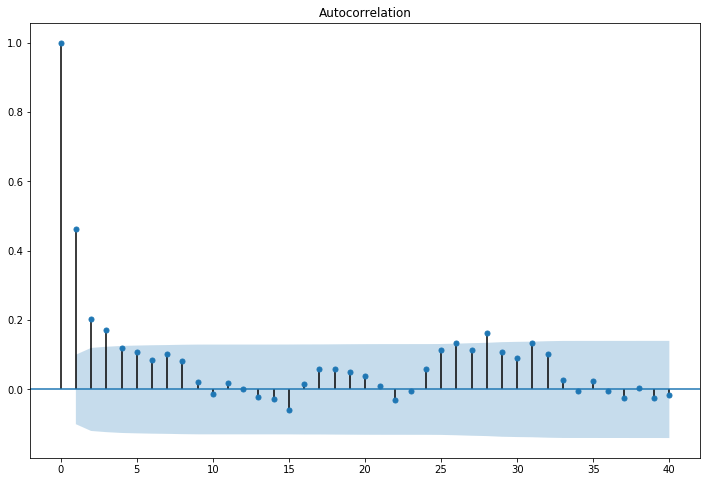

In [49]:
dickeyFullerPlot(dailyData['PT08.S3(NOx)'],40)
plotAutoCorr(dailyData['PT08.S3(NOx)'],40)

Dickey Fuller plot -> p < 0.001 < 0.05  ->  Data IS stationary

Autoregression plot shows small values mostly, data is seasonal. But values not _that_ low. Lets try to remove seasonality

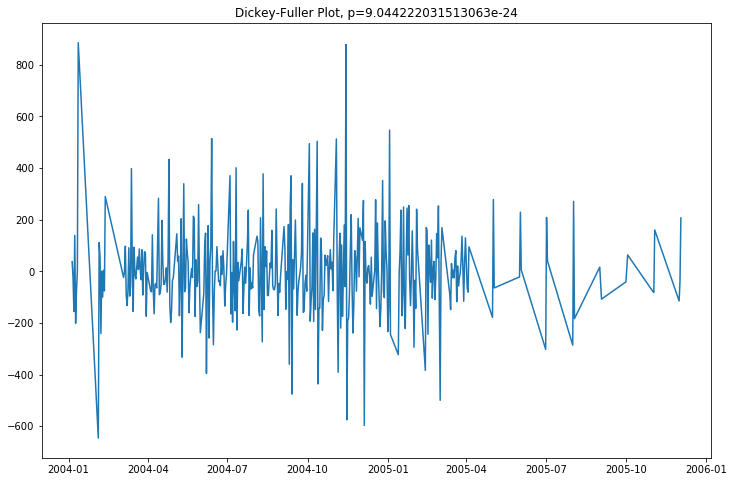

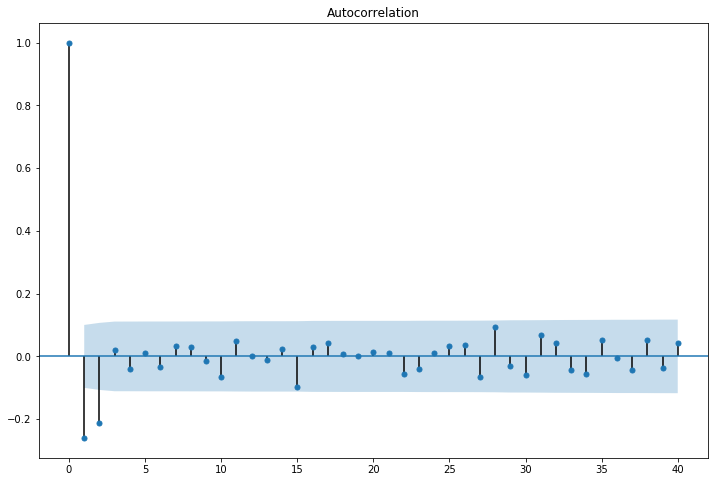

In [50]:
dataChangeInNOx=dailyData['PT08.S3(NOx)'] - dailyData['PT08.S3(NOx)'].shift(1)
dickeyFullerPlot(dataChangeInNOx[1:],40)
plotAutoCorr(dataChangeInNOx[1:],40)

Dickey Fuller plot -> p < 0.001 still stationary.

Autoregression plot shows much smaller values. Data is more seasonal

# Make Model

In [12]:
from fbprophet import Prophet

In [52]:
# Convert data to required format
df=dataChangeInNOx.reset_index()
df.columns=['ds', 'y']
df=df.iloc[1:]
df.head()

,ds,y
1,2004-01-05,37.416667
2,2004-01-06,-21.291667
3,2004-01-07,-155.875000
4,2004-01-08,139.166667
5,2004-01-09,-201.500000


In [53]:
train,test=df[:-40],df[-40:]
train.head()

,ds,y
1,2004-01-05,37.416667
2,2004-01-06,-21.291667
3,2004-01-07,-155.875000
4,2004-01-08,139.166667
5,2004-01-09,-201.500000


In [54]:
model=Prophet()
model.fit(train)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\rohan\anaconda3\envs\prophet\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [55]:
future = model.make_future_dataframe(periods=40)
forecast = model.predict(future)
forecast.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yhat
0,2004-01-05,6.136206,6.136206,6.136206,-270.960376,177.369248,-60.271181,-60.271181,-60.271181,0.0,0.0,0.0,-60.271181,-60.271181,-60.271181,-54.134975
1,2004-01-06,6.105177,6.105177,6.105177,-240.932340,217.897888,-20.152096,-20.152096,-20.152096,0.0,0.0,0.0,-20.152096,-20.152096,-20.152096,-14.046918
2,2004-01-07,6.074149,6.074149,6.074149,-260.149224,178.331915,-32.749314,-32.749314,-32.749314,0.0,0.0,0.0,-32.749314,-32.749314,-32.749314,-26.675165
3,2004-01-08,6.043121,6.043121,6.043121,-232.736802,214.253581,-2.794999,-2.794999,-2.794999,0.0,0.0,0.0,-2.794999,-2.794999,-2.794999,3.248122
4,2004-01-09,6.012093,6.012093,6.012093,-265.342816,181.558454,-30.581848,-30.581848,-30.581848,0.0,0.0,0.0,-30.581848,-30.581848,-30.581848,-24.569755


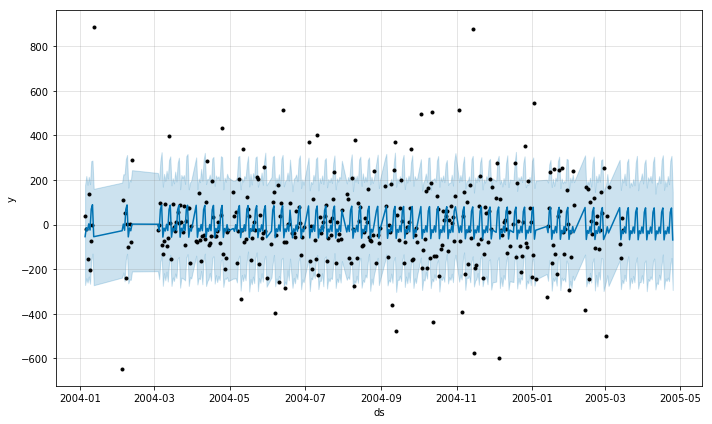

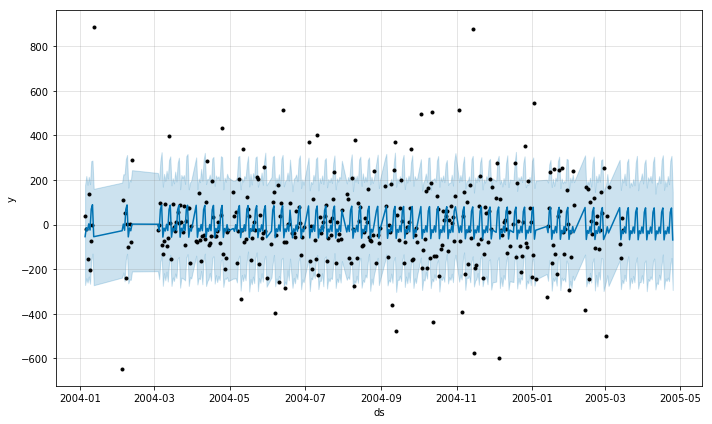

In [56]:
model.plot(forecast)

Light blue background -> Error             
Blue line spikes a lot, because its capturing trends within the week too. A weekly prediction would be smoother, but miss the daily trends                   

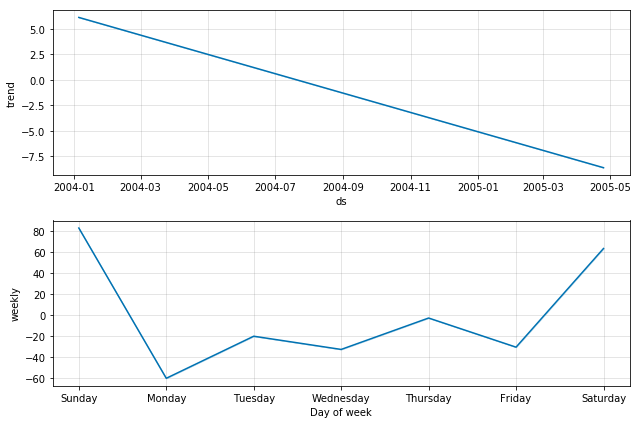

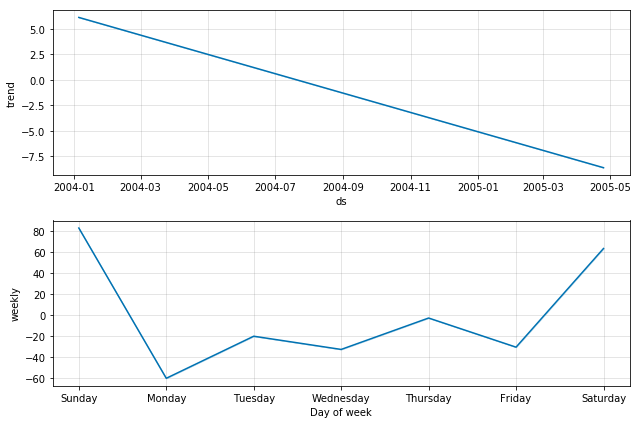

In [57]:
model.plot_components(forecast)

Trend is straight line downwards -> no seasonality identified                 
Weekly trends identified -> Air quality reduces towards the middle/end of the week

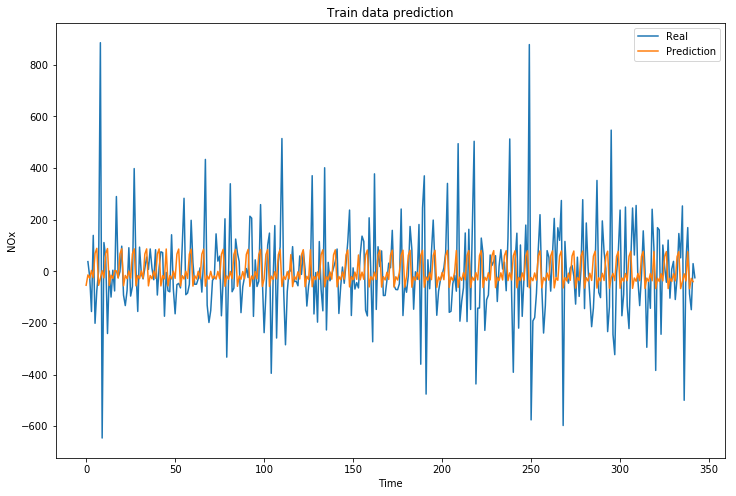

In [58]:
plt.figure(figsize=(12,8))
plt.plot(train.y)
plt.plot(forecast['yhat'][:-40])
plt.title("Train data prediction")
plt.legend(['Real','Prediction'])
plt.xlabel('Time')
plt.ylabel('NOx')
plt.show()

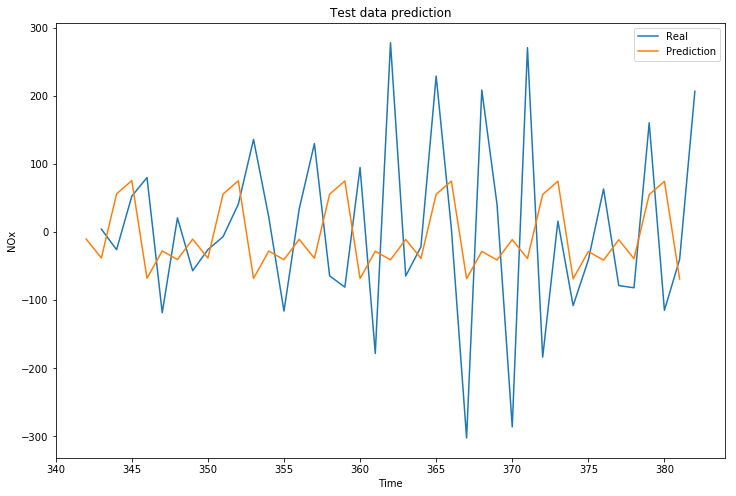

In [59]:
plt.figure(figsize=(12,8))
plt.plot(test.y)
plt.plot(forecast['yhat'][-40:])
plt.title("Test data prediction")
plt.legend(['Real','Prediction'])
plt.xlabel('Time')
plt.ylabel('NOx')
plt.show()

We can see prophet predicts seasonal trends, which are stationary.           
However, it is unable to capture the large spikes in the data. Might be because the variations are too frequent (daily). We can explore the use of weekly predictions instead.

In [60]:
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

In [61]:
preds=forecast['yhat']

In [62]:
print('MAE:',mean_absolute_error(test.y,preds[-40:]))
print('r^2:',r2_score(test.y,preds[-40:]))
print('MSE:',mean_squared_error(test.y,preds[-40:]))
print('RMSE:',mean_squared_error(test.y,preds[-40:],squared=False))

MAE: 105.49533989207389
r^2: -0.19787933740522368
MSE: 21116.000945635307
RMSE: 145.31345755171924


# Try predicting weekly

In [63]:
weeklyData.drop([col for col in weeklyData.columns if col!='PT08.S3(NOx)'],axis=1,inplace=True)
weeklyData.head()

,PT08.S3(NOx)
Date,
2004-01-04,880.666667
2004-01-11,760.484990
2004-01-18,1490.333333
2004-01-25,NaN
2004-02-01,NaN


In [67]:
# Convert data to required format
df=weeklyData.reset_index()
df.columns=['ds', 'y']
df.head()

,ds,y
0,2004-01-04,880.666667
1,2004-01-11,760.484990
2,2004-01-18,1490.333333
3,2004-01-25,NaN
4,2004-02-01,NaN


In [68]:
train,test=df[:-40],df[-40:]
train.head()

,ds,y
0,2004-01-04,880.666667
1,2004-01-11,760.484990
2,2004-01-18,1490.333333
3,2004-01-25,NaN
4,2004-02-01,NaN


In [69]:
model=Prophet()
model.fit(train)
future = model.make_future_dataframe(periods=40)
forecast = model.predict(future)
forecast.head()

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\rohan\anaconda3\envs\prophet\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2004-01-04,924.290347,924.290347,924.290347,757.409209,1096.635021,0.0,0.0,0.0,0.0,0.0,0.0,924.290347
1,2004-01-11,922.449306,922.449306,922.449306,756.279356,1087.476401,0.0,0.0,0.0,0.0,0.0,0.0,922.449306
2,2004-01-18,920.608265,920.608265,920.608265,736.220062,1089.984590,0.0,0.0,0.0,0.0,0.0,0.0,920.608265
3,2004-01-25,918.767186,918.767186,918.767186,754.519942,1081.922584,0.0,0.0,0.0,0.0,0.0,0.0,918.767186
4,2004-02-01,916.926106,916.926106,916.926106,738.740101,1082.072054,0.0,0.0,0.0,0.0,0.0,0.0,916.926106


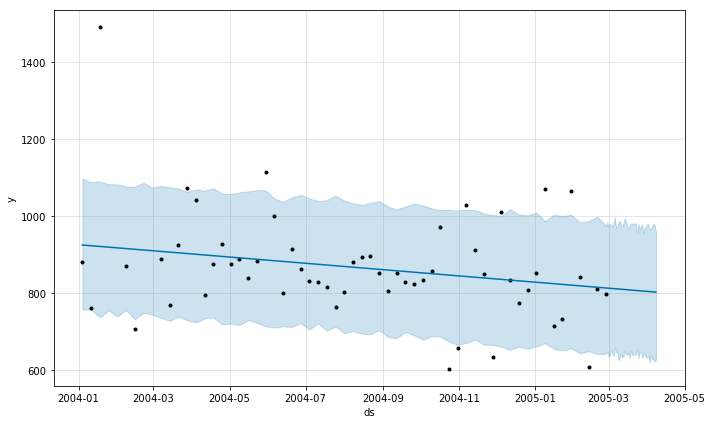

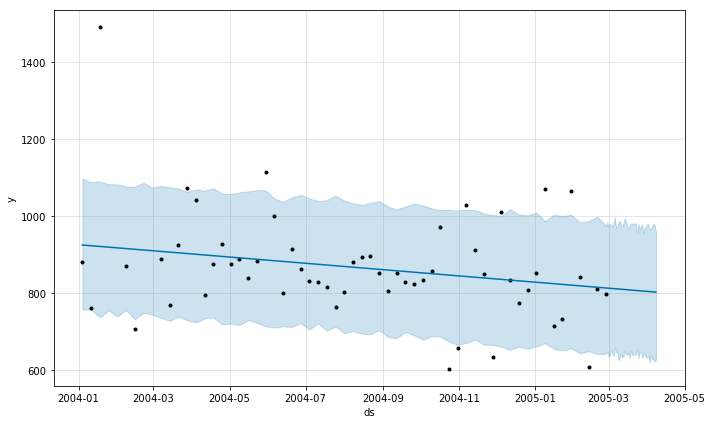

In [70]:
model.plot(forecast)

Predicted straight downward trend. Very smooth, but did not capture small dependencies.        
Large margin of error -> points very scattered

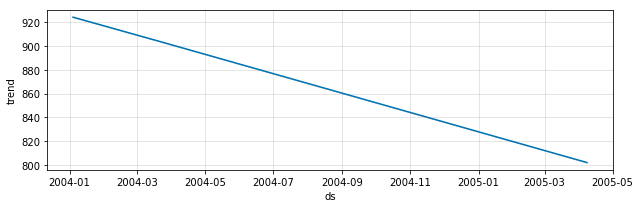

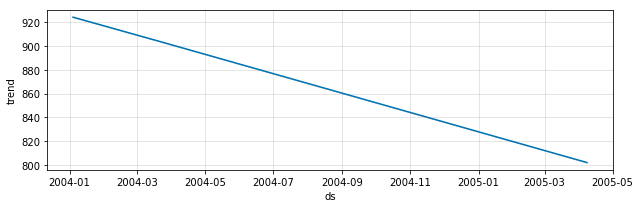

In [71]:
model.plot_components(forecast)

No seasonality or trends seen except for downward sloping

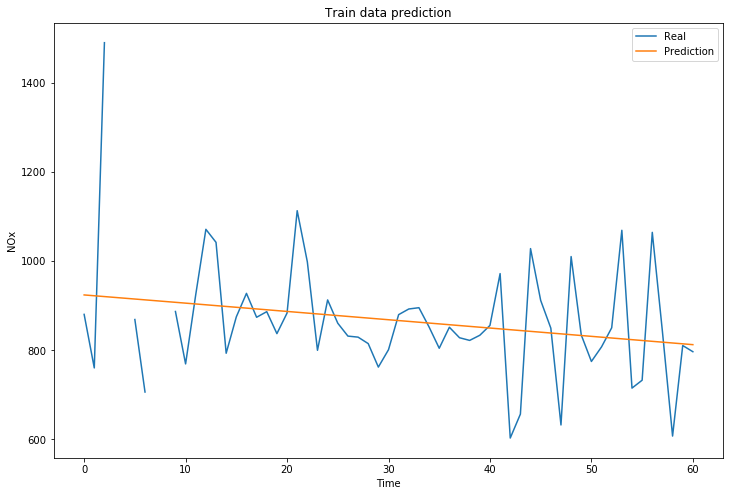

In [72]:
plt.figure(figsize=(12,8))
plt.plot(train.y)
plt.plot(forecast['yhat'][:-40])
plt.title("Train data prediction")
plt.legend(['Real','Prediction'])
plt.xlabel('Time')
plt.ylabel('NOx')
plt.show()

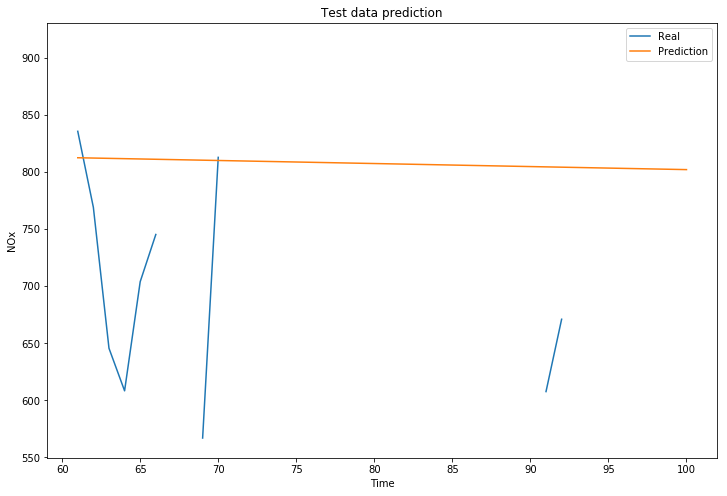

In [73]:
plt.figure(figsize=(12,8))
plt.plot(test.y)
plt.plot(forecast['yhat'][-40:])
plt.title("Test data prediction")
plt.legend(['Real','Prediction'])
plt.xlabel('Time')
plt.ylabel('NOx')
plt.show()

Missing weeks -> null values -> cant calculate scores